In [1]:
import tensorflow as tf
import keras
import pandas as pd
#import numpy as np
import minpy.numpy as np
#import minpy.numpy.random as random
from minpy.context import cpu, gpu
import matplotlib.pyplot as plt, matplotlib.image as mpimg
%matplotlib inline

labeled_images = pd.read_csv('First_assigment_handwritten_digits/train.csv')
images = labeled_images.iloc[:,1:]
labels = labeled_images.iloc[:,:1]

Using TensorFlow backend.


ModuleNotFoundError: No module named 'minpy'

In [ ]:
def forward(X, W, b, output_size, lambd = 0):
    assert W.shape == (X.shape[1], output_size)
    assert b.shape == (1, output_size)
    Z = np.dot(X, W) + b
    A = np.exp(Z)
    s = np.sum(A, axis = 1).reshape((X.shape[0], 1))
    A = (A / s) + 1e-15
    
    return A

def backward(X, Y, A):
    dZ = A - Y
    dW = np.dot(X.T, dZ) / X.shape[0]
    db = np.sum(dZ, axis = 0) / X.shape[0]
    
    return dW, db

def update(X, Y, W, b, output_size, learning_rate):
    A = forward(X, W, b, output_size)
    dW, db = backward(X, Y, A)
    
    J = -np.trace(np.dot(Y, np.log(A).T)) / X.shape[0]
    
    return W - learning_rate * dW, b - learning_rate * db, J

def predict(X, W, b, output_size):
    A = forward(X, W, b, output_size)
    return np.argmax(A, axis = 1)

In [ ]:
%%time
with gpu(0):
    m = 10000
    alpha = 0.1
    lambd = 0
    minibatch_size = 64
    iters = 500

    X = images.values[:m, :] / 256.
    Y = np.zeros((m, 10), dtype = np.int32)
    for i in range(m):
        Y[i, labels.values[i, :]] = 1

    W = np.random.rand(X.shape[1], 10)
    b = np.random.rand(1, 10)

    scores = np.array([])

    for epoch in range(iters):
        order = np.random.permutation(m)
        epoch_score = 0

        for i in range(0, m, minibatch_size):
            W, b, J = update(X[order[i : i + minibatch_size],:],\
                             Y[order[i : i + minibatch_size],:],\
                             W, b, 10, alpha)
            #epoch_score += J
            scores = np.append(scores, J)

    print(np.sum(predict(X, W, b, 10) == labels.values[:m, :].reshape((m, ))) / m)
    plt.plot(scores)

In [442]:
m_test = 10000
X_test = images.values[m : m + m_test, :] / 256.
np.sum(predict(X_test, W, b, 10) == labels.values[m : m + m_test, :].reshape((m_test, ))) / m_test

0.898

In [562]:
def get_model(name):
    x = tf.placeholder(tf.float32, [None, 784], name = 'x' + name)
    y = tf.placeholder(tf.float32, [None, 10], name = 'y' + name)
    out = tf.contrib.layers.fully_connected(x, 10, activation_fn = None)
    model = tf.nn.softmax(out)
    cost = tf.losses.softmax_cross_entropy(onehot_labels = y, logits = out)
    return model, cost

0.9713
Wall time: 1min 36s


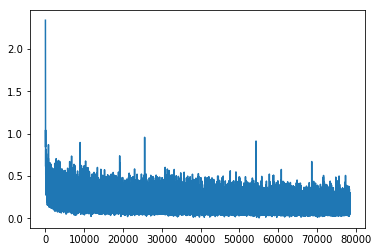

In [579]:
%%time
import time

name = str(time.time())
model, cost = get_model(name)
optimizer = tf.train.GradientDescentOptimizer(alpha).minimize(cost)
init = tf.global_variables_initializer()

scores = np.array([])

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(iters):
        order = np.random.permutation(m)

        for i in range(0, m, minibatch_size):
            _, J = sess.run([optimizer, cost], feed_dict = {'x' + name + ':0' : X[order[i : i + minibatch_size],:],\
                                                            'y' + name + ':0' : Y[order[i : i + minibatch_size],:]})
            scores = np.append(scores, J)
    predictions = sess.run([model], feed_dict = {'x' + name + ':0' : X, 'y' + name + ':0' : Y})[0]
print(np.sum(np.argmax(predictions, axis = 1) == np.argmax(Y, axis = 1)) / m)
plt.plot(scores)

In [585]:
J

0.29954842